# Кластеризация и SVM

## Ф.И.О: Бедрин Павел Александрович

In [1]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import adjusted_rand_score, accuracy_score
from sklearn.datasets import load_iris, make_classification, make_moons
from cvxopt import matrix, solvers
from collections import defaultdict

### Task 1: Реализация алгортим K-Means (6 points)

#### 1.1. Реализуйте алгоритм K-means без использования библиотек, реализующих данный метод (например, библиотеки sklearn) (3 points)

In [2]:
def k_means(X, k, max_iters=3, tol=1e-4):
    """ Реализуйте алгоритм K-Means """
    np.random.seed(42)

    k_random_indices = np.random.choice(X.shape[0], size=k, replace=False)
    centroids = X[k_random_indices]

    for _ in range(max_iters):
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)  # [N objects, N centroids, N features]
        nearest_centroids_indices = np.argmin(distances, axis=1)  # [N objects]
        new_centroids = np.array([X[nearest_centroids_indices == i].mean(axis=0) for i in range(k)])
        if np.linalg.norm(new_centroids - centroids) < tol:
            break
        centroids = new_centroids
    
    return nearest_centroids_indices, centroids
    

# Automatic Checker
def check_k_means():
    iris = load_iris()
    X = iris.data
    y_true = iris.target

    labels_custom, centroids_custom = k_means(X, k=3)
    kmeans_sklearn = KMeans(n_clusters=3, random_state=42, n_init=10).fit(X)
    labels_sklearn = kmeans_sklearn.labels_

    score_custom = adjusted_rand_score(y_true, labels_custom)
    score_sklearn = adjusted_rand_score(y_true, labels_sklearn)
    print(score_custom)
    print(score_sklearn)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.scatter(X[:, 0], X[:, 1], c=labels_custom, cmap='viridis', marker='o')
    plt.scatter(centroids_custom[:, 0], centroids_custom[:, 1], s=300, c='red', marker='X')
    plt.title('K-Means Clustering')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')

    assert labels_custom is not None, "Function should return labels."
    assert len(labels_custom) == len(X), "Should return labels for all points."
    assert score_custom > 0.7, "Clustering should achieve a higher score."
    print(f"Task 1.1 Passed! Adjusted Rand Score: {score_custom:.2f}")

0.7195837484778036
0.7302382722834697
Task 1.1 Passed! Adjusted Rand Score: 0.72


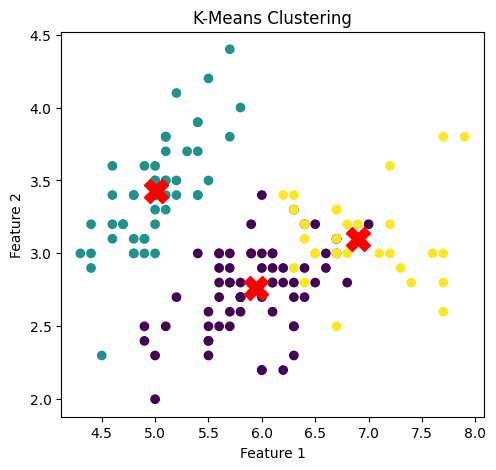

In [3]:
check_k_means()

#### 1.2. Реализуйте алгоритм K-means++ без использования библиотек, реализующих данный метод (например, библиотеки sklearn) (3 points)

In [46]:
def initialize_plus_plus(X, k):
    """ Инициализируйте центры кластеров """
    np.random.seed(42)

    centroids = [X[np.random.choice(X.shape[0])]]

    for _ in range(k - 1):
        # Object -> nearest centroid
        min_distances = np.min(np.linalg.norm(X[:, np.newaxis] - centroids, axis=2), axis=1)  # [N objects, N features]
        probs = min_distances ** 2
        probs /= np.sum(probs)
        centroids.append(X[np.random.choice(X.shape[0], p=probs)])

    return np.array(centroids)


def k_means_plus_plus(X, k, max_iters=100, tol=1e-4):
    """ Реализуйте алгоритм K-means++ """
    centroids = initialize_plus_plus(X, k)

    for _ in range(max_iters):
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)  # [N objects, N centroids, N features]
        nearest_centroids_indices = np.argmin(distances, axis=1)  # [N objects]
        new_centroids = np.array([X[nearest_centroids_indices == i].mean(axis=0) for i in range(k)])
        if np.linalg.norm(new_centroids - centroids) < tol:
            break
        centroids = new_centroids
    
    return nearest_centroids_indices, centroids

# Automatic Checker
def check_k_means_plus_plus():
    iris = load_iris()
    X = iris.data
    y_true = iris.target

    labels_custom, centroids_custom = k_means_plus_plus(X, k=3)
    kmeans_sklearn = KMeans(n_clusters=3, init='k-means++', random_state=42, n_init=10).fit(X)
    labels_sklearn = kmeans_sklearn.labels_

    score_custom = adjusted_rand_score(y_true, labels_custom)
    score_sklearn = adjusted_rand_score(y_true, labels_sklearn)
    print(score_custom)
    print(score_sklearn)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.scatter(X[:, 0], X[:, 1], c=labels_custom, cmap='viridis', marker='o')
    plt.scatter(centroids_custom[:, 0], centroids_custom[:, 1], s=300, c='red', marker='X')
    plt.title('K-Means++ Clustering')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')

    assert labels_custom is not None, "Function should return labels."
    assert len(labels_custom) == len(X), "Should return labels for all points."
    assert score_custom > 0.7, "Clustering should achieve a higher score."
    print(f"Task 1.2 Passed! Adjusted Rand Score: {score_custom:.2f}")


0.7163421126838476
0.7302382722834697
Task 1.2 Passed! Adjusted Rand Score: 0.72


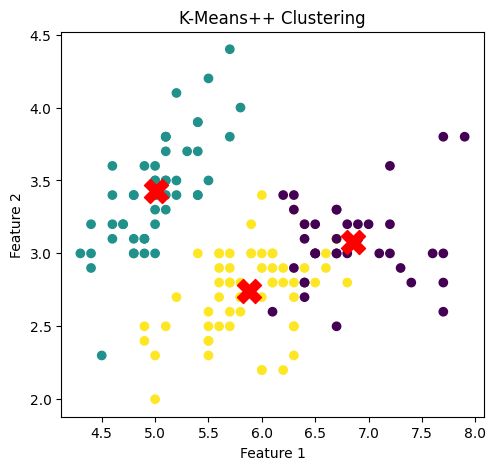

In [47]:
check_k_means_plus_plus()

### Task 2: Оценка алгоритма DBSCAN (4 points)

Вы анализируете движение такси в городе, чтобы определить популярные зоны посадки. У Вас есть набор данных, представляющий места посадки такси.

```
data_points = [
    (1.2, 3.1), (2.5, 3.3), (1.8, 2.9), (8.2, 7.5),
    (8.1, 7.7), (25.3, 80.2), (2.0, 3.0), (3.0, 3.5),
    (1.1, 1.2), (90.0, 91.2), (1.5, 3.2), (8.0, 7.6),
    (2.2, 3.1), (7.9, 7.8), (1.3, 3.0)
]
```

Каждая точка представляет посадку такси с координатами (x, y) в километрах от центра города.

С помощью алгортима DBSCAN сгруппируйте эти поездки на такси, чтобы определить зоны с высокой плотностью посадки (Выберите максимальное расстояние между точками = 1.5 и минимальное число точек в группе = 3), а какие зоны посадки являются случайными выбросами.

Для решения этой задачи не используйте библиотеки с реализацией DBSCAN (например, библиотеки sklearn)

In [49]:
class Dbscan:
    def __init__(self, max_radius, min_points):
        self.max_radius = max_radius
        self.min_points = min_points

    def get_nearest_points_indices(self, target_point_idx):
        return np.array([idx for idx in range(self.X.shape[0])
                         if np.linalg.norm(self.X[idx] - self.X[target_point_idx]) <= self.max_radius])
    
    def form_cluster(self, point_idx, nearest_points_indices, cluster_idx):
        self.cluster_indices[point_idx] = cluster_idx

        for point_idx in nearest_points_indices:
            if self.cluster_indices[point_idx] == 0:                
                self.cluster_indices[point_idx] = cluster_idx

                # Recursion from neighbor
                neighbor_nearest_points_indices = self.get_nearest_points_indices(point_idx)
                if len(neighbor_nearest_points_indices) >= self.min_points:
                    self.form_cluster(point_idx, neighbor_nearest_points_indices, cluster_idx)

            elif self.cluster_indices[point_idx] == -1:
                self.cluster_indices[point_idx] = cluster_idx

    def fit(self, X):
        self.X = X
        self.cluster_indices = [0] * X.shape[0]
        cluster_idx = 1
        for point_idx in range(X.shape[0]):
            if self.cluster_indices[point_idx] != 0:
                continue
            nearest_points_indices = self.get_nearest_points_indices(point_idx)
            if len(nearest_points_indices) >= self.min_points:
                self.form_cluster(point_idx, nearest_points_indices, cluster_idx)
                cluster_idx += 1
            else:
                self.cluster_indices[point_idx] = -1
    
    def fit_predict(self, X):
        self.fit(X)
        return self.cluster_indices


data_points = [
    (1.2, 3.1), (2.5, 3.3), (1.8, 2.9), (8.2, 7.5),
    (8.1, 7.7), (25.3, 80.2), (2.0, 3.0), (3.0, 3.5),
    (1.1, 1.2), (90.0, 91.2), (1.5, 3.2), (8.0, 7.6),
    (2.2, 3.1), (7.9, 7.8), (1.3, 3.0)
]

dbscan = Dbscan(max_radius=1.5, min_points=3)
cluster_indices = dbscan.fit_predict(np.array(data_points))

label2points = defaultdict(list)
for cluster_idx, point in zip(cluster_indices, data_points):
    label2points[cluster_idx].append(point)

for cluster_idx, points in label2points.items():
    print_label = "Noise" if cluster_idx == -1 else f"Cluster {cluster_idx}"
    print(f"{print_label}: {points}")

Cluster 1: [(1.2, 3.1), (2.5, 3.3), (1.8, 2.9), (2.0, 3.0), (3.0, 3.5), (1.5, 3.2), (2.2, 3.1), (1.3, 3.0)]
Cluster 2: [(8.2, 7.5), (8.1, 7.7), (8.0, 7.6), (7.9, 7.8)]
Noise: [(25.3, 80.2), (1.1, 1.2), (90.0, 91.2)]


Text(0, 0.5, 'y')

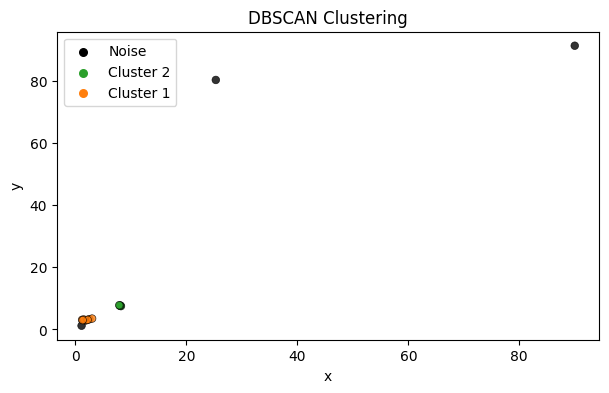

In [51]:
plt.figure(figsize=(7, 4))
X = np.array(data_points)

labels = []
colors = []
for cluster_idx in cluster_indices:
    labels.append("Noise" if cluster_idx == -1 else f"Cluster {cluster_idx}")
    if cluster_idx == -1:
        colors.append("black")
    else:
        colors.append(plt.cm.tab10.colors[cluster_idx])

# Legend part
unique = list(set(zip(labels, colors)))
for label, color in unique:
    plt.scatter([], [], color=color, label=label, s=30)
plt.legend(loc="best")

plt.scatter(X[:, 0], X[:, 1], c=colors, s=30, alpha=0.8, edgecolor='k', linewidth=0.5)
plt.title('DBSCAN Clustering')
plt.xlabel('x')
plt.ylabel('y')

У нас получилось 2 зоны с высокой плотностью посадки и 3 точки-выброса.

### Task 3 Оценка алгоритма SVM (4 points)

Рассмотрим набор данных в 2D-пространстве, где первые два значения - это координаты точек, а третье значение - метка класса:

```
data_points = [
    (-4, 2, 1), (-1, -1, -1), (0, -2, -1), (1, -2, -1),
    (2, 3, 1), (3, 3, 1), (4, 4, 1), (-4, -3, -1), (-5, -2, -1),
    (5, 2, 1), (6, 1, 1), (-6, -1, -1), (-7, -3, -1), (7, 3, 1),
    (8, 4, 1), (-8, -5, -1), (9, 5, 1), (-9, -4, -1), (10, 6, 1),
]
```

1. Определите уравнение прямой, которая наилучшим образом разделяет два класса.
2. Определите величину зазора (margin) и вектор, ортогональный разделяющей границе
3. Определите, какие точки являются опорными векторами.


Сначала отделим признаки от меток классов и изобразим точки на графике:

Text(0, 0.5, 'y')

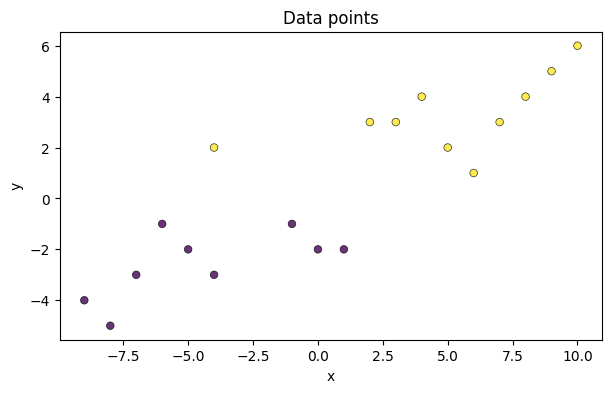

In [96]:
data_points = np.array([
    (-4, 2, 1), (-1, -1, -1), (0, -2, -1), (1, -2, -1),
    (2, 3, 1), (3, 3, 1), (4, 4, 1), (-4, -3, -1), (-5, -2, -1),
    (5, 2, 1), (6, 1, 1), (-6, -1, -1), (-7, -3, -1), (7, 3, 1),
    (8, 4, 1), (-8, -5, -1), (9, 5, 1), (-9, -4, -1), (10, 6, 1),
])
X, y = data_points[:, :2], data_points[:, 2]  # X is (x, y), y is cluster label

plt.figure(figsize=(7, 4))
plt.scatter(X[:, 0], X[:, 1], c=y, s=30, alpha=0.8, edgecolor='k', linewidth=0.5)
plt.title('Data points')
plt.xlabel('x')
plt.ylabel('y')

Теперь применим SVC из sklearn, покажем разделение на графике и ответим на вопросы:

1. Уравнение разделяющей прямой: 0.07x + 0.74y -0.19 = 0
2. Величина зазора: 2.69
   Ортогональный вектор: [0.07, 0.74]
3. Опорные векторы: 
[[-1. -1.]
 [-4.  2.]
 [ 6.  1.]]


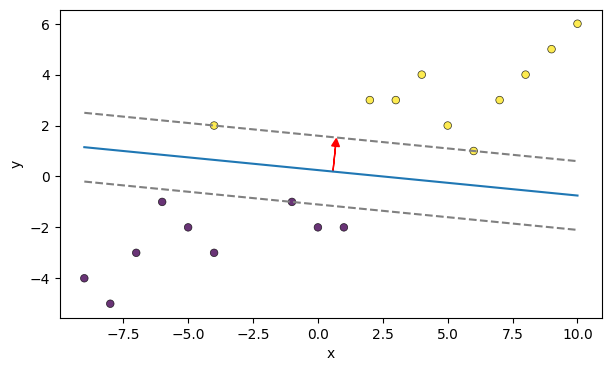

In [114]:
svm = SVC(kernel="linear")
svm.fit(X, y)

# Уравнение разделяющей прямой: w_0 x + w_1 y + b = 0
# y = -(w_0 / w_1)x - b/w_1
w = svm.coef_[0]
b = svm.intercept_[0]
decision_boundary_str = f"{w[0]:.2f}x + {w[1]:.2f}y {b:.2f} = 0"
print(f"1. Уравнение разделяющей прямой: {decision_boundary_str}")

x_dots = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
y_dots = -(w[0] / w[1]) * x_dots - b / w[1]

# Разделяющая прямая
plt.figure(figsize=(7, 4))
plt.scatter(X[:, 0], X[:, 1], c=y, s=30, alpha=0.8, edgecolor='k', linewidth=0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.plot(x_dots, y_dots)

# Зазор
margin = 2 / np.sqrt(np.sum(svm.coef_ ** 2))
margin_up = y_dots + 1 / w[1]
margin_down = y_dots - 1 / w[1]
plt.plot(x_dots, margin_down, color='gray', linestyle='dashed')
plt.plot(x_dots, margin_up, color='gray', linestyle='dashed')
print(f"2. Величина зазора: {margin:.2f}")

# Ортогональный вектор
x_point = np.mean(X[:, 0])
y_point = -(w[0] / w[1]) * x_point - b / w[1]
w_norm = w / np.linalg.norm(w)
plt.arrow(x_point, y_point, w_norm[0], w_norm[1],
          head_width=0.3, head_length=0.3, fc='red', ec='red')
print(f"   Ортогональный вектор: [{w[0]:.2f}, {w[1]:.2f}]")

print(f"3. Опорные векторы: \n{svm.support_vectors_}")

### Task 4 Реализация алгоритма SVM (6 points)

#### 4.1. Реализуйте алгоритм Linear SVM без использования библиотек, реализующих данный метод (например, библиотеки sklearn) (3 points)

In [46]:
def linear_svm(X, y, learning_rate=0.001, lambda_param=0.01, n_iters=1000):
    """ Реализуйте Linear SVM """
    np.random.seed(42)
    w = np.zeros(X.shape[1])
    b = 0

    for _ in range(n_iters):
        for i, x_i in enumerate(X):
            if y[i] * (np.dot(x_i, w) - b) >= 1:
                w -= learning_rate * 2 * lambda_param * w
            else:
                w -= learning_rate * (2 * lambda_param * w - np.dot(x_i, y[i]))
                b -= learning_rate * y[i]
    
    return w, b
    

def predict_svm(X, weights, bias):
    return np.sign(np.dot(X, weights) - bias)

# Automatic Checker
def check_linear_svm():
    X, y = make_classification(n_samples=1000, n_features=4, n_informative=2, n_redundant=0, random_state=42)
    y = np.where(y == 0, -1, 1)

    X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

    weights, bias = linear_svm(X, y)
    y_pred = predict_svm(X, weights, bias)

    svm_sklearn = SVC(kernel='linear', random_state=42)
    svm_sklearn.fit(X, y)
    y_pred_sklearn = svm_sklearn.predict(X)

    accuracy = accuracy_score(y, y_pred)
    accuracy_sklearn = accuracy_score(y, y_pred_sklearn)

    assert accuracy > 0.85, "Accuracy should be higher"
    print(f"Task 4.1 Passed! Accuracy: {accuracy:.2f}")

In [47]:
check_linear_svm()

Task 4.1 Passed! Accuracy: 0.87


#### Task 4.2: Реализуйте Kernel SVM с использованием RBF ядра без использования библиотек, реализующих данный метод (например, библиотеки sklearn) (3 points)

In [105]:
def rbf_kernel(X, Y=None, gamma=0.1):
    if Y is None:
        Y = X
    """ Определите RBF kernel """
    sq_X = np.sum(X ** 2, axis=1, keepdims=True)
    sq_Y = np.sum(Y ** 2, axis=1, keepdims=True)
    diff_norm = sq_X - 2 * X @ Y.T + sq_Y.T
    kernel = np.exp(- gamma * diff_norm)
    return kernel

def kernel_svm(X, y, gamma=0.1, learning_rate=0.001, lambda_param=0.01, n_iters=1000):
    """ Реализуйте Kernel SVM """
    np.random.seed(42)
    alpha = np.zeros(X.shape[0])
    k = rbf_kernel(X, X, gamma)

    for _ in range(n_iters):
        grad = (k * np.outer(y, y)) @ alpha - 1
        alpha -= learning_rate * grad
        alpha = np.maximum(0, alpha)
    
    return alpha

def predict_kernel_svm(X, X_train, y_train, alpha, gamma=0.1):
    K = rbf_kernel(X, X_train, gamma)
    return np.sign(np.dot(K, alpha * y_train))

# Automatic Checker
def check_kernel_svm():
    X, y = make_moons(n_samples=50, noise=0.01, random_state=42)
    y = np.where(y == 0, -1, 1)

    alpha = kernel_svm(X, y)
    y_pred = predict_kernel_svm(X, X, y, alpha)

    svm_sklearn = SVC(kernel='rbf', gamma=0.1, random_state=42)
    svm_sklearn.fit(X, y)
    y_pred_sklearn = svm_sklearn.predict(X)

    accuracy = accuracy_score(y, y_pred)
    accuracy_sklearn = accuracy_score(y, y_pred_sklearn)

    print(accuracy)
    print(accuracy_sklearn)

    assert accuracy > 0.8, "Accuracy should be higher"
    print(f"Task 4.2 Passed! Accuracy: {accuracy:.2f}")

In [106]:
check_kernel_svm()

0.84
0.84
Task 4.2 Passed! Accuracy: 0.84
